In [1]:
import numpy as np
#from scipy.signal import butter, filtfilt
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
%matplotlib inline
#import seaborn as sns
#sns.set_context("notebook", font_scale=1.3,
#                rc={'lines.linewidth': 1.5, 'lines.markersize': 14, 'axes.titlesize': 'x-large'})
#matplotlib.rc('legend', numpoints=1, fontsize=14)
#import glob
import sys, os
sys.path.insert(1, r'./Functions')
# IPython widgets:
from IPython.display import display
import ipywidgets
from ipywidgets import FloatProgress, interactive
import seaborn as sns
from scipy.signal import detrend

In [2]:
#!pip install version_information
%load_ext version_information
%version_information numpy, scipy, pandas, matplotlib, seaborn

Software versions
Python 3.8.8 64bit [MSC v.1916 64 bit (AMD64)]
IPython 7.22.0
OS Windows 10 10.0.22621 SP0
numpy 1.20.1
scipy 1.6.2
pandas 1.2.4
matplotlib 3.3.4
seaborn 0.11.1
Mon Jun 26 20:19:11 2023 Hora oficial do Brasil

In [3]:
# GitHub URL:
#path2 = 'C:\Users\ferna\Downloads\IC- dados\Dados'
# local directory:
path2 = r'C:\\Users\\ferna\\Downloads\\IC- dados\\Dados'
fname = os.path.join(path2, 'PDSinfo.txt')
PDSinfo = pd.read_csv(fname, sep='\t', header=0, index_col=None, engine='c', encoding='utf-8')
print(fname)
print("Information of %s subjects loaded (%s rows, %s columns)."
      %(len(pd.unique(PDSinfo.Subject)), PDSinfo.shape[0], PDSinfo.shape[1]))

C:\\Users\\ferna\\Downloads\\IC- dados\\Dados\PDSinfo.txt
Information of 49 subjects loaded (588 rows, 29 columns).


In [4]:
a=PDSinfo[PDSinfo['Subject']==44].index.tolist()
e=PDSinfo[PDSinfo['Subject']==44].index.tolist()[2]

In [5]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
fs = 100 # Hz
COPX = np.zeros((49, 60*fs-30))
COPZ = np.zeros((49, 60*fs-30))

COPXreal = np.zeros((49, 60*fs-30))
COPYreal = np.zeros((49, 60*fs-30))
COPZreal = np.zeros((49, 60*fs-30))

d1x = np.zeros((49, 60*fs-30))
d2x = np.zeros((49, 60*fs-30))

d1z = np.zeros((49, 60*fs-30))
d2z = np.zeros((49, 60*fs-30))

matrizangx = np.zeros((49, 60*fs-30))
matrizangz = np.zeros((49, 60*fs-30))

alpha = np.zeros((49, 60*fs-30))

COGX = np.zeros((49, 60*fs-30))
COGY = np.zeros((49,60*fs-30))
COGZ = np.zeros((49, 60*fs-30))  

for s in range (1,50):
    a = PDSinfo[PDSinfo['Subject']==s].index.tolist()[2]
    
    fname_grf = os.path.join(path2, PDSinfo.Trial[a] + 'grf' + '.txt') 
    fname_mkr = os.path.join(path2, PDSinfo.Trial[a] + 'mkr' + '.txt')
    grf = pd.read_csv(fname_grf, delimiter='\t', header=0, engine='c')
    mkr = pd.read_csv(fname_mkr, delimiter='\t', header=0, engine='c')
    colunas = mkr.columns
    #print(list(colunas))
    COGX[s-1,:]=mkr['COG_X'].values[30:]
    COGY[s-1,:]=mkr['COG_Y'].values[30:]
    COGZ[s-1,:]=mkr['COG_Z'].values[30:]
    #print(COGX)
    mass=PDSinfo['Mass']
    d = np.sqrt(COGX[s-1,:]**2+COGY[s-1,:]**2+COGZ[s-1,:]**2)
    angulox = np.arcsin(COGX[s-1,:]/d)
    anguloz= np.arcsin(COGZ[s-1,:]/d)
    sinx=np.sin(angulox)
    sinz=np.sin(anguloz)
    cosx=np.cos(angulox)
    cosz=np.cos(anguloz)
    tanx=np.tan(angulox)
    tanz=np.tan(anguloz)
    matrizangx[s-1,:] = angulox
    matrizangz[s-1,:] = anguloz
    
    
    Jb=(4/3)*(mass.values[s])*((d)**2)
    t=grf['Time']
    dt=t[1]-t[0]

    d1x[s-1,:]=np.gradient(matrizangx[s-1,:],dt)
    d1z[s-1,:]=np.gradient(matrizangz[s-1,:],dt)

    d2x[s-1,:]=np.gradient(d1x[s-1,:],dt)
    d2z[s-1,:]=np.gradient(d1z[s-1,:],dt)
    
    COPX[s-1,:] = d*sinx + Jb/(mass.values[s]*9.8)*(sinx*d1x[s-1,:]**2-cosx*d2x[s-1,:])
    COPZ[s-1,:] = d*sinz + Jb/(mass.values[s]*9.8)*(sinz*d1z[s-1,:]**2-cosz*d2z[s-1,:])
    
    
    COPXreal[s-1,:]=grf['COPNET_X'].values[30:]
    COPZreal[s-1,:]=grf['COPNET_Z'].values[30:]
    

    
    x= np.vstack((COPX[[s-1],:],d2x[[s-1],:]))
    y= COPXreal[s-1,:]

    model=LinearRegression(fit_intercept=False)
    model.fit(x.T,y)
    
    
    split=train_test_split(COGX,COPXreal,test_size=9)
    COGXtrain = split[0]
    COPXtrain = split[1]
    COGXtest = split[2]
    COPXtest = split[3]
    
#print(COGXtrain)
#for i in COGXtrain:
 #   i=0
#print(COGXtrain[i])
    
    
    
    
    #print(model.coef_) 
    
    #def reg_m(y, x):
        #ones = np.ones(len(x[0]))
        #X = sm.add_constant(np.column_stack((x[0], ones)))
        #for oi in x[1:]:
            #X = sm.add_constant(np.column_stack((oi, X)))
            #results = sm.OLS(y, x).fit()
            #return results
    #print(model.coef_)
    #print(reg_m(y, x.T).summary())
 
    #print(model.coef_)
    #x= (np.array([COPX[s-1,:],d2x[s-1,:]]))
    #y= COPXreal[s-1,:]
    #model=LinearRegression()
    #model.fit(x.T,y)
    #print(model.coef_) 
    #Histogramas
    #plt.figure()
    #hist=plt.hist(model.coef_[0], bins=50)
    #plt.title('Histograms of alpha'.format(s))
    #plt.show()


In [6]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
fs = 100 # Hz
COPX = np.zeros((49, 60*fs-30))
COPZ = np.zeros((49, 60*fs-30))

COPXreal = np.zeros((49, 60*fs-30))
COPYreal = np.zeros((49, 60*fs-30))
COPZreal = np.zeros((49, 60*fs-30))

d1x = np.zeros((49, 60*fs-30))
d2x = np.zeros((49, 60*fs-30))

d1z = np.zeros((49, 60*fs-30))
d2z = np.zeros((49, 60*fs-30))

matrizangx = np.zeros((49, 60*fs-30))
matrizangz = np.zeros((49, 60*fs-30))

alpha = np.zeros((49, 60*fs-30))


GTRX = np.zeros((49, 60*fs-30))
GTRY = np.zeros((49,60*fs-30))
GTRZ = np.zeros((49, 60*fs-30))

subject = np.zeros((0,1))
j=0

for s in range (1,50):
    a = PDSinfo[PDSinfo['Subject']==s].index.tolist()[2]
    
    fname_grf = os.path.join(path2, PDSinfo.Trial[a] + 'grf' + '.txt') 
    fname_mkr = os.path.join(path2, PDSinfo.Trial[a] + 'mkr' + '.txt')
    grf = pd.read_csv(fname_grf, delimiter='\t', header=0, engine='c')
    mkr = pd.read_csv(fname_mkr, delimiter='\t', header=0, engine='c')
    colunas = mkr.columns
    #print(list(colunas))
    GTRX[s-1,:]=mkr['R.GTR_X'].values[30:]
    GTRY[s-1,:]=mkr['R.GTR_Y'].values[30:]
    GTRZ[s-1,:]=mkr['R.GTR_Z'].values[30:]
    #print(COGX)
    mass=PDSinfo['Mass']
    d = np.sqrt(GTRX[s-1,:]**2+GTRY[s-1,:]**2+GTRZ[s-1,:]**2)
    angulox = np.arcsin(GTRX[s-1,:]/d)
    anguloz= np.arcsin(GTRZ[s-1,:]/d)
    sinx=np.sin(angulox)
    sinz=np.sin(anguloz)
    cosx=np.cos(angulox)
    cosz=np.cos(anguloz)
    tanx=np.tan(angulox)
    tanz=np.tan(anguloz)
    matrizangx[s-1,:] = angulox
    matrizangz[s-1,:] = anguloz
    
    
    
    Jb=(4/3)*(mass.values[s])*((d)**2)
    t=grf['Time']
    dt=t[1]-t[0]

    d1x[s-1,:]=np.gradient(matrizangx[s-1,:],dt)
    d1z[s-1,:]=np.gradient(matrizangz[s-1,:],dt)

    d2x[s-1,:]=np.gradient(d1x[s-1,:],dt)
    d2z[s-1,:]=np.gradient(d1z[s-1,:],dt)
    
    COPX[s-1,:] = d*sinx + Jb/(mass.values[s]*9.8)*(sinx*d1x[s-1,:]**2-cosx*d2x[s-1,:])
    COPZ[s-1,:] = d*sinz + Jb/(mass.values[s]*9.8)*(sinz*d1z[s-1,:]**2-cosz*d2z[s-1,:])
    
   
    
    
    COPXreal[s-1,:]=grf['COPNET_X'].values[30:]
    COPZreal[s-1,:]=grf['COPNET_Z'].values[30:]
    
    subject = np.vstack((subject, [s]))
    


In [7]:
indices = np.arange(1,50).reshape(-1,1)
np.random.shuffle(indices)
train = indices[:40]
test = indices[40:]

masstrain = mass.values[train]
masstest = mass.values[test]

np.in1d(subject,train)
GTRXtrain = GTRX[np.in1d(subject,train),:]
GTRXtest = GTRX[np.in1d(subject,test),:]
COPXtrain = COPX[np.in1d(subject,train),:]
COPXtest = COPX[np.in1d(subject,test),:]
GTRYtrain = GTRY[np.in1d(subject,train),:]
GTRYtest = GTRY[np.in1d(subject,test),:]

GTRZtrain =GTRZ[np.in1d(subject,train),:]
GTRZtest =GTRZ[np.in1d(subject,test),:]
COPZtrain = COPZ[np.in1d(subject,train),:]
COPZtest = COPZ[np.in1d(subject,test),:]



Função erro

In [8]:
def centerofpressure(paramt, M,x,y,z):
    from sklearn.model_selection import train_test_split
    from scipy.optimize import minimize, rosen, rosen_der
    from sklearn.metrics import mean_squared_error
    COPXES = np.zeros((len(x), 60*fs-30))
    COPXESorig =np.zeros((len(x), 60*fs-30))
    for i in range(0,len(x)):
        d = np.sqrt(x[i]**2+y[i]**2+z[i]**2)
        angulox = np.arcsin(x[i]/d)
        anguloz = np.arcsin(z[i]/d)
        sinx=np.sin(angulox)
        sinz=np.sin(anguloz)
        cosx=np.cos(angulox)
        cosz=np.cos(anguloz)
        tanx=np.tan(angulox)
        tanz=np.tan(anguloz)
        matrizangx[i,:] = angulox
        matrizangz[i,:] = anguloz
        A,alpha,beta, gama = paramt
        

        sennovo = sinx*A + ((1-A**2)**1/2)*cosx

        cosnovo = cosx*A - ((1-A**2)**1/2)*sinx

        Jb=(4/3)*(M[i])*((d)**2)
        t=grf['Time']
        dt=t[1]-t[0]

        d1x[i,:]=np.gradient(matrizangx[i,:],dt)
        d1z[i,:]=np.gradient(matrizangz[i,:],dt)



        d2x[i,:]=np.gradient(d1x[i,:],dt)
        d2z[i,:]=np.gradient(d1z[i,:],dt)

        COPX[i,:] = d*sennovo + Jb/(M[i]*9.8)*(sennovo*d1x[i,:]**2-cosnovo*d2x[i,:])
        COPZ[i,:] = d*sinz + Jb/(M[i]*9.8)*(sinz*d1z[i,:]**2-cosz*d2z[i,:])
        
        COPXES[i,:] = alpha*(d*sennovo + ((Jb/(M[i]*9.8))*sennovo*d1x[i,:]**2)) + d2x[i,:]*(-alpha*cosnovo*Jb/(M[i]*9.8)+beta) + gama
        COPXESorig[i,:]= COPX[i,:]
        
        
    
    return COPXES
        


    

In [9]:
def meansquarerror(paramt):
    
    from sklearn.metrics import mean_squared_error
    
    A,alpha,beta, gama = paramt
        
    ytrue = COPXtrain
    ypredicted = centerofpressure(paramt,masstrain,GTRXtrain,GTRYtrain,GTRZtrain)
        
        
    
    return mean_squared_error(ytrue, ypredicted)
        


    

In [10]:
from sklearn.model_selection import train_test_split
#from scipy import optmize
from scipy.optimize import minimize, rosen, rosen_der
first_guess = [0,0,0,0]
res = minimize(meansquarerror, first_guess)
coeficientes = res.x
print(coeficientes)
A=coeficientes[0]
alpha=coeficientes[1]
beta=coeficientes[2]
gama=coeficientes[3]

[ 9.99933648e-01  9.99895628e-01  3.86789911e-05 -1.89332389e-05]


Test

In [11]:

treinando=centerofpressure(coeficientes, masstrain,GTRXtrain,GTRYtrain,GTRZtrain) 

testando=centerofpressure(coeficientes, masstest,GTRXtest,GTRYtest,GTRZtest)


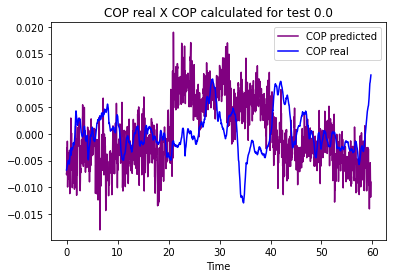

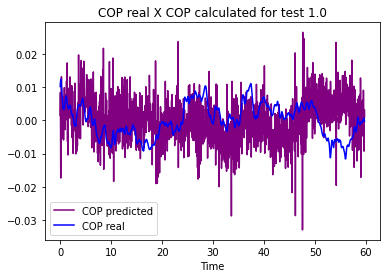

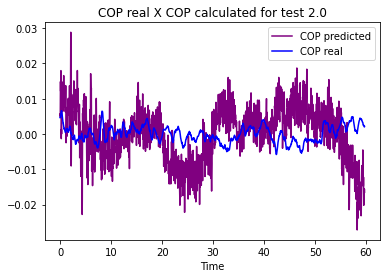

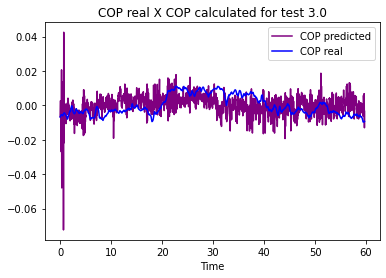

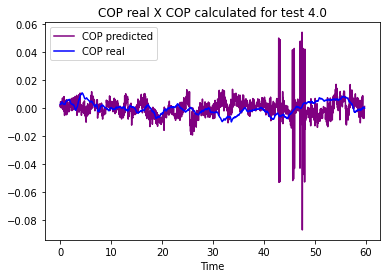

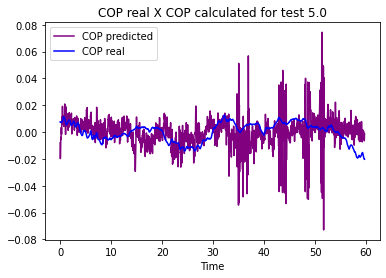

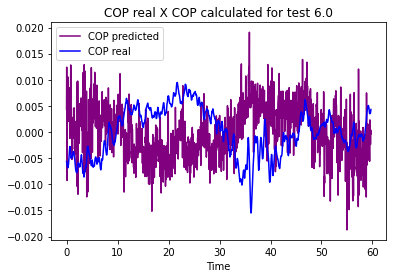

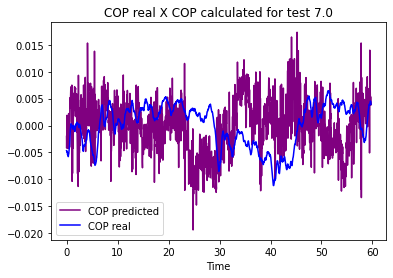

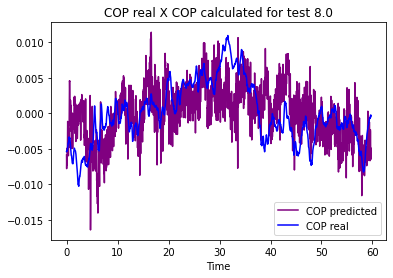

In [12]:
time = np.arange(0,6000)/100
for i in range(0,len(GTRXtest)):
    plt.figure()
    plt.plot(time[:5970],detrend(testando[i,:]),color='purple',label='COP predicted')
    plt.plot(time[:5970],detrend(COPXreal[i]),color='blue', label='COP real')
    plt.title('COP real X COP calculated for test {:.1f}'.format(i))
    plt.xlabel('Time')
    plt.legend()
    plt.show()

In [13]:
sennovo = sinx*A + ((1-A**2)**1/2)*cosx
print(np.max(sennovo))
print(np.min(sennovo))

0.3194131696834049
0.2967985785506853


In [14]:
cosnovo = cosx*A - ((1-A**2)**1/2)*sinx
print(np.max(cosnovo))
print(np.min(cosnovo))

0.9548706245050946
0.9475455307293983
